# Lab 6.5.3: PCR and PLS Regression

Adapted from http://www.science.smith.edu/~jcrouser/SDS293/labs/

In [81]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 4) # number precision for pandas
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.5f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

In [82]:
hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end

hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 1]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 1]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 1]

X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

## Principal Components Regression

In [83]:
from sklearn.preprocessing import scale 
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

In [84]:
pca = PCA()
X_pca = pca.fit_transform(scale(X))
pd.DataFrame(X_pca)

,0,1,2,3,4,5,...,13,14,15,16,17,18
0,-0.00965,1.87052,1.26515,-0.93548,1.10964,1.21197,...,0.38841,0.06360,0.14479,0.08022,0.03814,-0.01925
1,0.41143,-2.42942,-0.90919,-0.26421,1.23203,1.82662,...,-0.01939,0.06515,0.16106,0.04434,0.01483,-0.00339
2,3.46682,0.82595,0.55547,-1.61673,-0.85749,-1.02871,...,-0.37620,0.23429,0.01153,-0.21828,0.03783,-0.06650
3,-2.55832,-0.23098,0.51964,-2.17625,-0.82030,1.49170,...,0.02897,0.04246,0.05304,-0.04444,0.01036,-0.01358
4,1.02770,-1.57354,1.33138,3.49400,0.98343,0.51368,...,-0.09077,0.04381,0.01230,-0.05059,0.12604,-0.07104
5,-3.98066,1.50728,-0.15548,0.36984,-1.20933,0.03351,...,-0.23885,0.19311,-0.05744,0.05253,-0.02404,0.02506
6,-3.45172,0.59999,-0.62648,1.99978,0.80703,0.20597,...,0.17209,-0.08701,-0.04808,-0.01407,-0.02805,0.00072
7,-3.43238,0.11354,1.99975,0.76781,1.01609,-0.27280,...,0.28443,0.00656,0.06495,-0.05982,-0.06718,-0.00480
8,3.89971,1.94787,-1.82047,-0.02671,-1.13713,-0.82105,...,0.64407,-0.00599,-0.10877,0.13175,-0.05793,-0.02276
9,3.17481,-2.39237,0.79447,2.56901,-0.94733,-0.06125,...,-0.27270,-0.29059,-0.09460,0.05480,-0.02855,0.02771


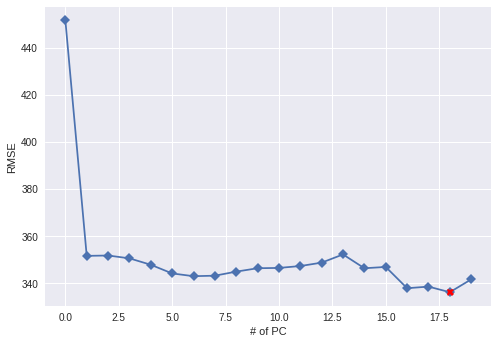

In [85]:
# 10-fold CV, with shuffle
n = len(X_pca)
k10 = KFold(n, n_folds=10, shuffle=True, random_state=42)

lin_reg = LinearRegression()
rmse = []

# MSE with only the intercept
score = -1 * cross_val_score(lin_reg, np.ones((n,1)), y, cv=k10, scoring='neg_mean_squared_error').mean()
rmse.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg, X_pca[:,:i], y, cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()
    
plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE');

In [86]:
np.cumsum(pca.explained_variance_ratio_*100)

array([  38.31423957,   60.15531541,   70.8416746 ,   79.03419435,
         84.29027516,   88.63477938,   92.26288766,   94.96304322,
         96.28269124,   97.25541298,   97.97775424,   98.64870031,
         99.15178693,   99.4730334 ,   99.74659124,   99.89398793,
         99.96815949,   99.99375108,  100.        ])

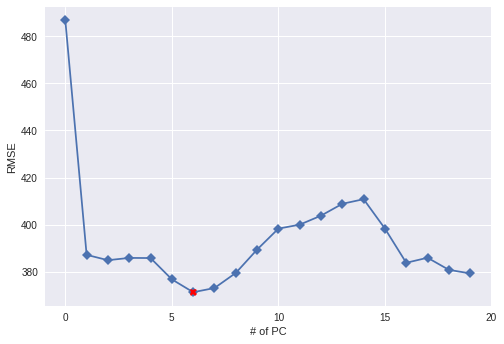

In [87]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

pca2 = PCA()
X_train_pca2 = pca2.fit_transform(scale(X_train))

# 10-fold CV, with shuffle
n = len(X_train_pca2)
k102 = KFold(n, n_folds=10, shuffle=True, random_state=1)

lin_reg2 = LinearRegression()
rmse2 = []

# MSE with only the intercept
score = -1 * cross_val_score(lin_reg2, np.ones((n,1)), y_train, cv=k102, scoring='neg_mean_squared_error').mean()
rmse2.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg2, X_train_pca2[:,:i], y_train, cv=k102, scoring='neg_mean_squared_error').mean()
    rmse2.append(np.sqrt(score))

min_rmse = np.array(rmse2).argmin()
    
plt.plot(rmse2, '-D')
plt.plot(rmse2, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0, 5, 10, 15, 20]);

In [88]:
X_train_pca3 = pca2.fit_transform(scale(X_train))[:, :7]
X_test_pca3 = pca2.fit_transform(scale(X_test))[:, :7]

lin_reg3 = LinearRegression()
lin_reg3.fit(X_train_pca3, y_train)
pred_pca3 = lin_reg3.predict(X_test_pca3)

mean_squared_error(y_test, pred_pca3)

114098.056320663

## Partial Least Squares

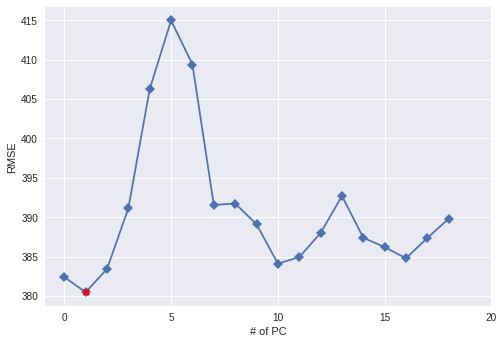

In [89]:
# 10-fold CV, with shuffle
n = len(X_train)
k10 = KFold(n, n_folds=10, shuffle=True, random_state=1)

rmse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, scale(X_train), y_train, cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()

plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0, 5, 10, 15, 20]);

In [90]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104711.20627773693